In [4]:
%%capture
!sudo apt update
!sudo apt-get install texlive-latex-extra texlive-fonts-recommended dvipng cm-super

In [3]:
%%capture
!pip install colorspacious adjustText svgutils

### Mount Google Drive and move to it

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Imports

In [6]:
import os
import re
import gzip
import lzma
import zipfile
import json
import pathlib
from itertools import chain

import base64
import inspect
import importlib

from natsort import natsorted

import numpy as np
import pandas as pd
from tqdm.auto import tqdm, trange

from IPython.display import SVG, Image
import svgutils.transform as sg

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import *
from matplotlib.colors import ListedColormap
from matplotlib.lines import Line2D
from adjustText import adjust_text

sns.set(font_scale=2.5, rc={'text.usetex' : True}, style="whitegrid")

In [7]:
%cd /content/drive/MyDrive/Mutants-in-pcm

/content/drive/MyDrive/Mutants-in-pcm


### Read results

Aggregate all results for PCM and QSAR for both types of cross validations:
- random 5-fold CV
- mutant-grouped KFold CV

In [68]:
data = []
# PCM random CV
for fpath in natsorted(pathlib.Path('.').glob('*pcm_random*')):
    accession = fpath.as_posix().split('_')[2].split('.')[0]
    subset = pd.read_csv(fpath.as_posix(), sep='\t', index_col=0).reset_index()
    subset['accession'] = accession
    subset['modeltype'] = 'PCM'
    subset['crossval'] = 'random'
    data.append(subset)
# PCM per mutant CV
for fpath in natsorted(pathlib.Path('.').glob('*pcm_mutant*')):
    accession = fpath.as_posix().split('_')[2].split('.')[0]
    subset = pd.read_csv(fpath.as_posix(), sep='\t', index_col=0).reset_index()
    subset['accession'] = accession
    subset['modeltype'] = 'PCM'
    subset['crossval'] = 'per mutant'
    data.append(subset)
# QSAR random CV
for fpath in natsorted(pathlib.Path('.').glob('*qsar_random*')):
    accession = fpath.as_posix().split('_')[2].split('.')[0]
    subset = pd.read_csv(fpath.as_posix(), sep='\t', index_col=0).reset_index()
    subset['accession'] = accession
    subset['modeltype'] = 'QSAR'
    subset['crossval'] = 'random'
    data.append(subset)
# QSAR per mutant CV
for fpath in natsorted(pathlib.Path('.').glob('*pcm_mutant*')):
    accession = fpath.as_posix().split('_')[2].split('.')[0]
    subset = pd.read_csv(fpath.as_posix(), sep='\t', index_col=0).reset_index()
    subset['accession'] = accession
    subset['modeltype'] = 'QSAR'
    subset['crossval'] = 'per mutant'
    data.append(subset)
data = pd.concat(data)
data = data.rename(columns={'index': 'folds'})
# data = data.set_index(['accession', 'folds'])
data

,folds,number,R2,MSE,RMSE,MSLE,RMSLE,MAE,Explained Variance,Max Error,...,Pearson r,Spearman r,Kendall tau,R2_0 (pred. vs. obs.),R'2_0 (obs. vs. pred.),k slope (pred. vs obs.),k' slope (obs. vs pred.),accession,modeltype,crossval
0,Fold 1,53.000000,0.882975,0.122713,0.350304,0.002839,0.053286,0.256465,0.886017,1.024599,...,0.944569,0.895565,0.748184,0.887494,0.854220,0.983721,1.012627,A0A045ISB3,PCM,random
1,Fold 2,52.000000,0.779375,0.223104,0.472339,0.005362,0.073224,0.312449,0.780358,1.607675,...,0.883457,0.854368,0.697923,0.780213,0.730736,0.987108,1.005414,A0A045ISB3,PCM,random
2,Fold 3,52.000000,0.820794,0.135056,0.367499,0.003219,0.056732,0.272644,0.824033,1.045130,...,0.919769,0.883315,0.731193,0.827458,0.845343,1.008704,0.986800,A0A045ISB3,PCM,random
3,Fold 4,52.000000,0.871301,0.145360,0.381261,0.003254,0.057047,0.272669,0.876834,1.147290,...,0.939435,0.912867,0.759820,0.878760,0.843788,0.978316,1.017353,A0A045ISB3,PCM,random
4,Fold 5,52.000000,0.885644,0.135362,0.367916,0.003369,0.058047,0.253924,0.888690,1.303812,...,0.943299,0.872708,0.716555,0.887962,0.862617,1.005131,0.990336,A0A045ISB3,PCM,random
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,Fold 31,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.994087,1.005948,Q72874,QSAR,per mutant
31,Fold 32,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.907319,1.102148,Q72874,QSAR,per mutant
32,Fold 33,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.960579,1.041039,Q72874,QSAR,per mutant
33,Mean,125.575758,-1.477339,0.787077,0.663512,0.010022,0.073442,0.570767,0.048202,1.262119,...,0.325921,0.316330,0.273819,0.060164,-1.236411,1.001783,0.994882,Q72874,QSAR,per mutant


In [69]:
num_data_points = (data[(data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD']))]
                        .groupby('accession')
                        .agg({'number': 'sum'})
                        .sort_values('number', ascending=False)
                        .reset_index()
)

In [70]:
order = data[(data.modeltype == 'PCM') & (data.crossval == 'random') & (data.folds == 'Mean')].sort_values('number', ascending=False).accession[:]
data = data[data.accession.isin(order)]
data['accession'] = data.accession.astype("category")
data['accession'] = data.accession.cat.set_categories(order)

### Carry out t-tests

In [72]:
metrics = 'Pearson r'

In [73]:
from scipy.stats import ttest_ind

replacements = {}
for accession in order:
    # Isolate values of each fold
    x1 = data[(data.accession == accession) & (data.modeltype == 'PCM') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD']))][metrics]
    x2 = data[(data.accession == accession) & (data.modeltype == 'QSAR') & (data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD']))][metrics]
    # Carry out t-test
    t_test = ttest_ind(x1, x2, equal_var=False)
    if t_test.pvalue < 0.01:
        replacements[accession] = '* ' + accession
old_accessions = {value: key for key, value in replacements.items()}
data['accession'] = data.accession.cat.rename_categories(replacements)

<ipython-input-74-0e8371a25183>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
<ipython-input-74-0e8371a25183>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])


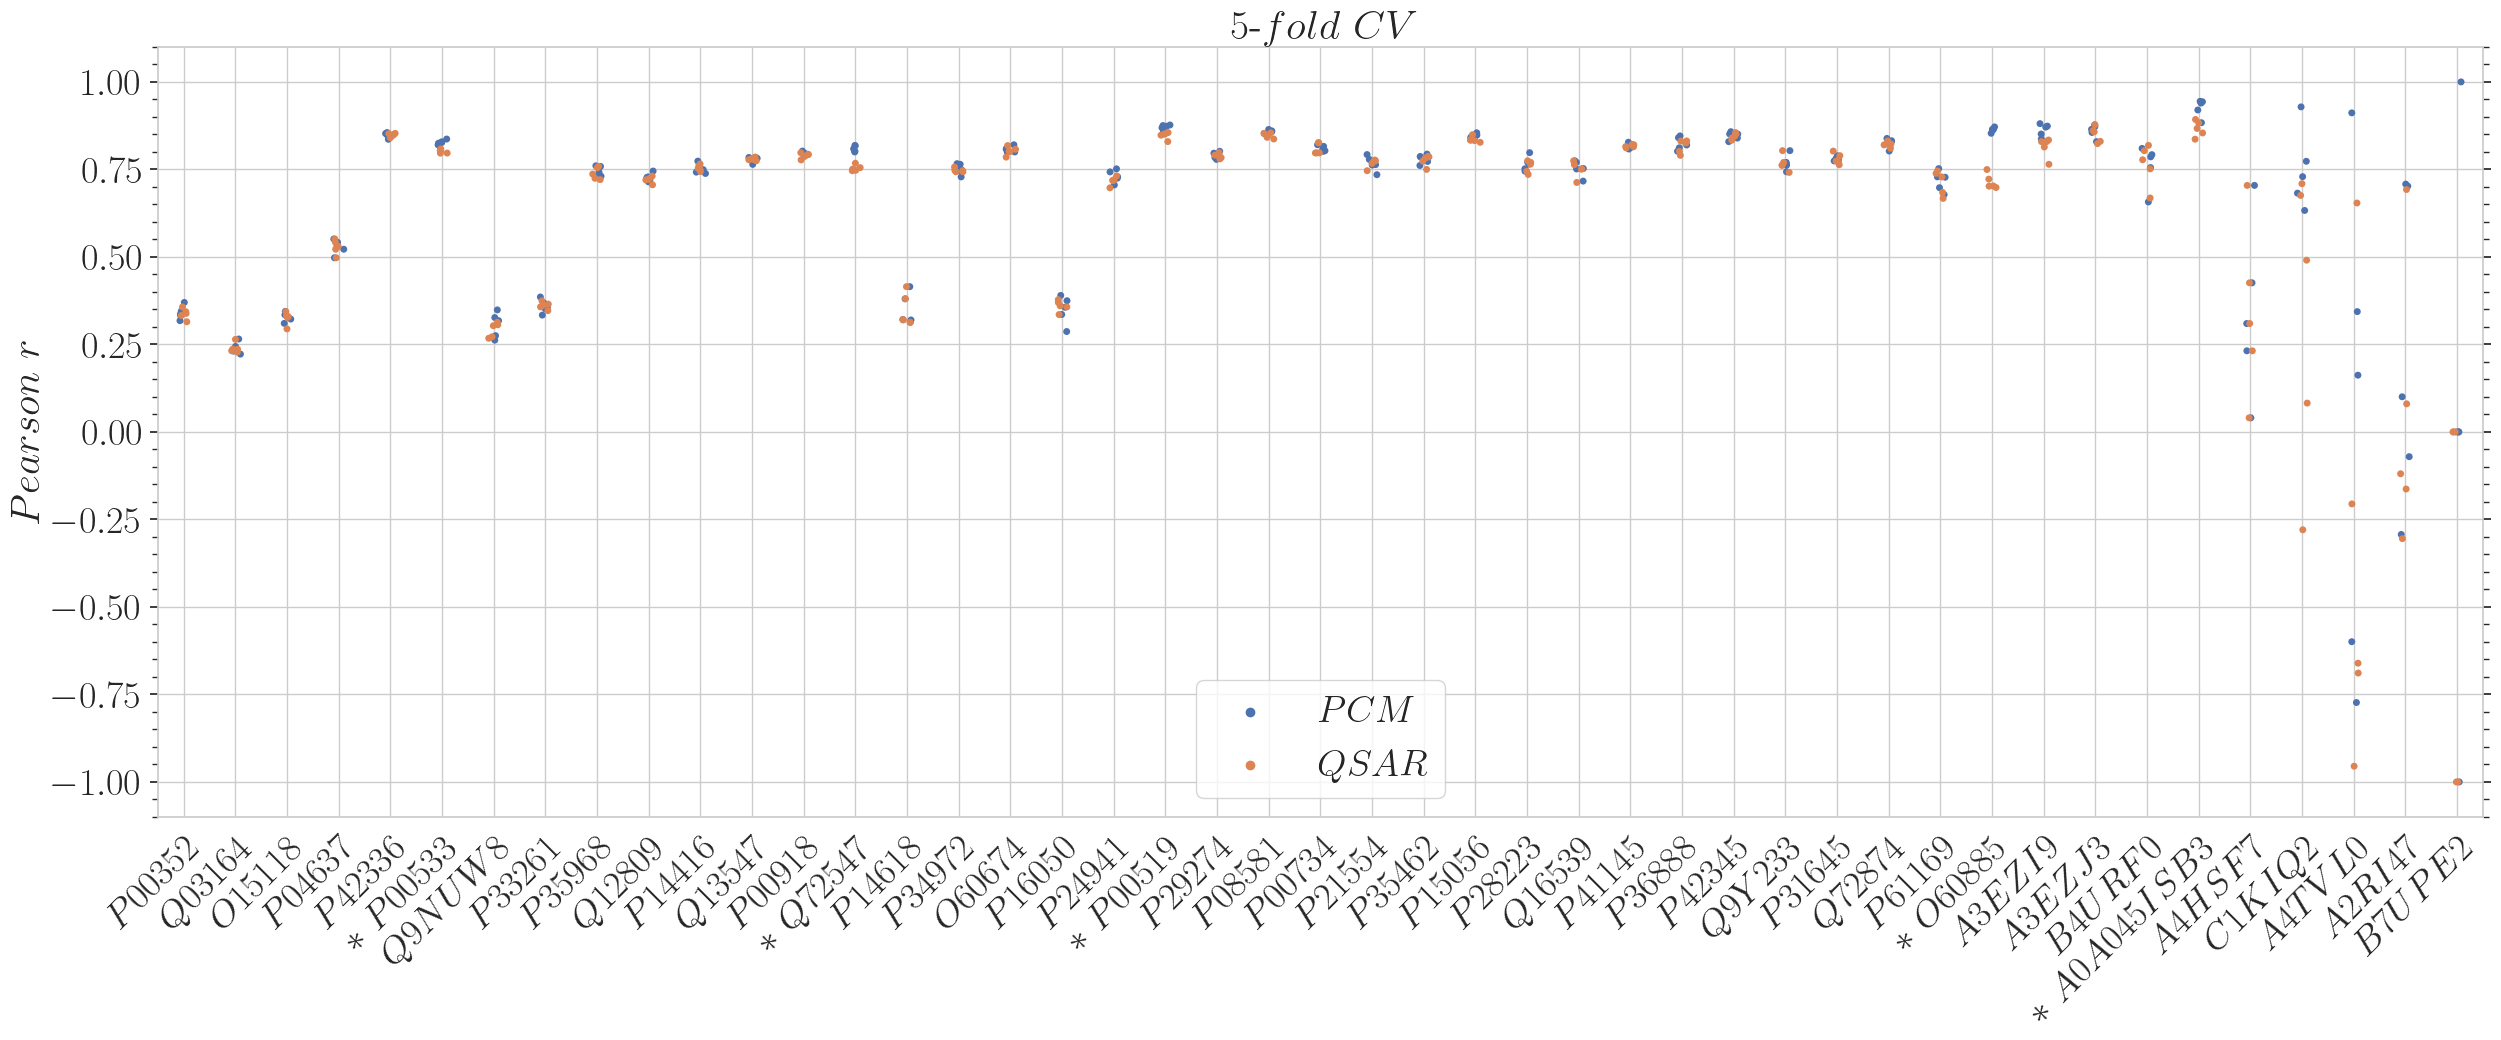

In [74]:
fig, ax = plt.subplots(figsize=(30, 10))

# Plot data
sns.stripplot(data=data[(data.crossval == 'random') & (~data.folds.isin(['Mean', 'SD']))].reset_index(),
              x='accession', hue='modeltype', y=metrics, ax=ax)
# Set title, axes labels and y limits
_ = ax.set(title='$5$-$fold$ $CV$', xlabel='', ylabel=' '.join(f'${word}$' for word in metrics.split()), ylim=(-1.1, 1.1))
# Rotate and right align x labels
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# Adapt legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc='lower center')
l = ax.get_legend()
mappings = {'PCM': '$PCM$', 'QSAR': '$QSAR$'}
for text in l.get_texts():
    _ = text.set_text(mappings[text.get_text()])
# Add minor ticks on y axis
ax.tick_params(axis='y', which='both', reset=True, direction='out')
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# Set grid on
ax.grid(True)
# Latex-ify x labels
_ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])

Now with the LOMO (leave one mutant out) CV.

In [75]:
# Reset accession names
data['accession'] = data.accession.cat.rename_categories(old_accessions)

replacements = {}
for accession in order:
    # Isolate values of each fold
    x1 = data[(data.accession == accession) & (data.modeltype == 'PCM') & (data.crossval == 'per mutant') & (~data.folds.isin(['Mean', 'SD']))][metrics]
    x2 = data[(data.accession == accession) & (data.modeltype == 'QSAR') & (data.crossval == 'per mutant') & (~data.folds.isin(['Mean', 'SD']))][metrics]
    # Carry out t-test
    t_test = ttest_ind(x1, x2, equal_var=False)
    if t_test.pvalue < 0.01:
        replacements[accession] = '* ' + accession
old_accessions = {value: key for key, value in replacements.items()}
data['accession'] = data.accession.cat.rename_categories(replacements)

<ipython-input-76-e7872181314a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
<ipython-input-76-e7872181314a>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])


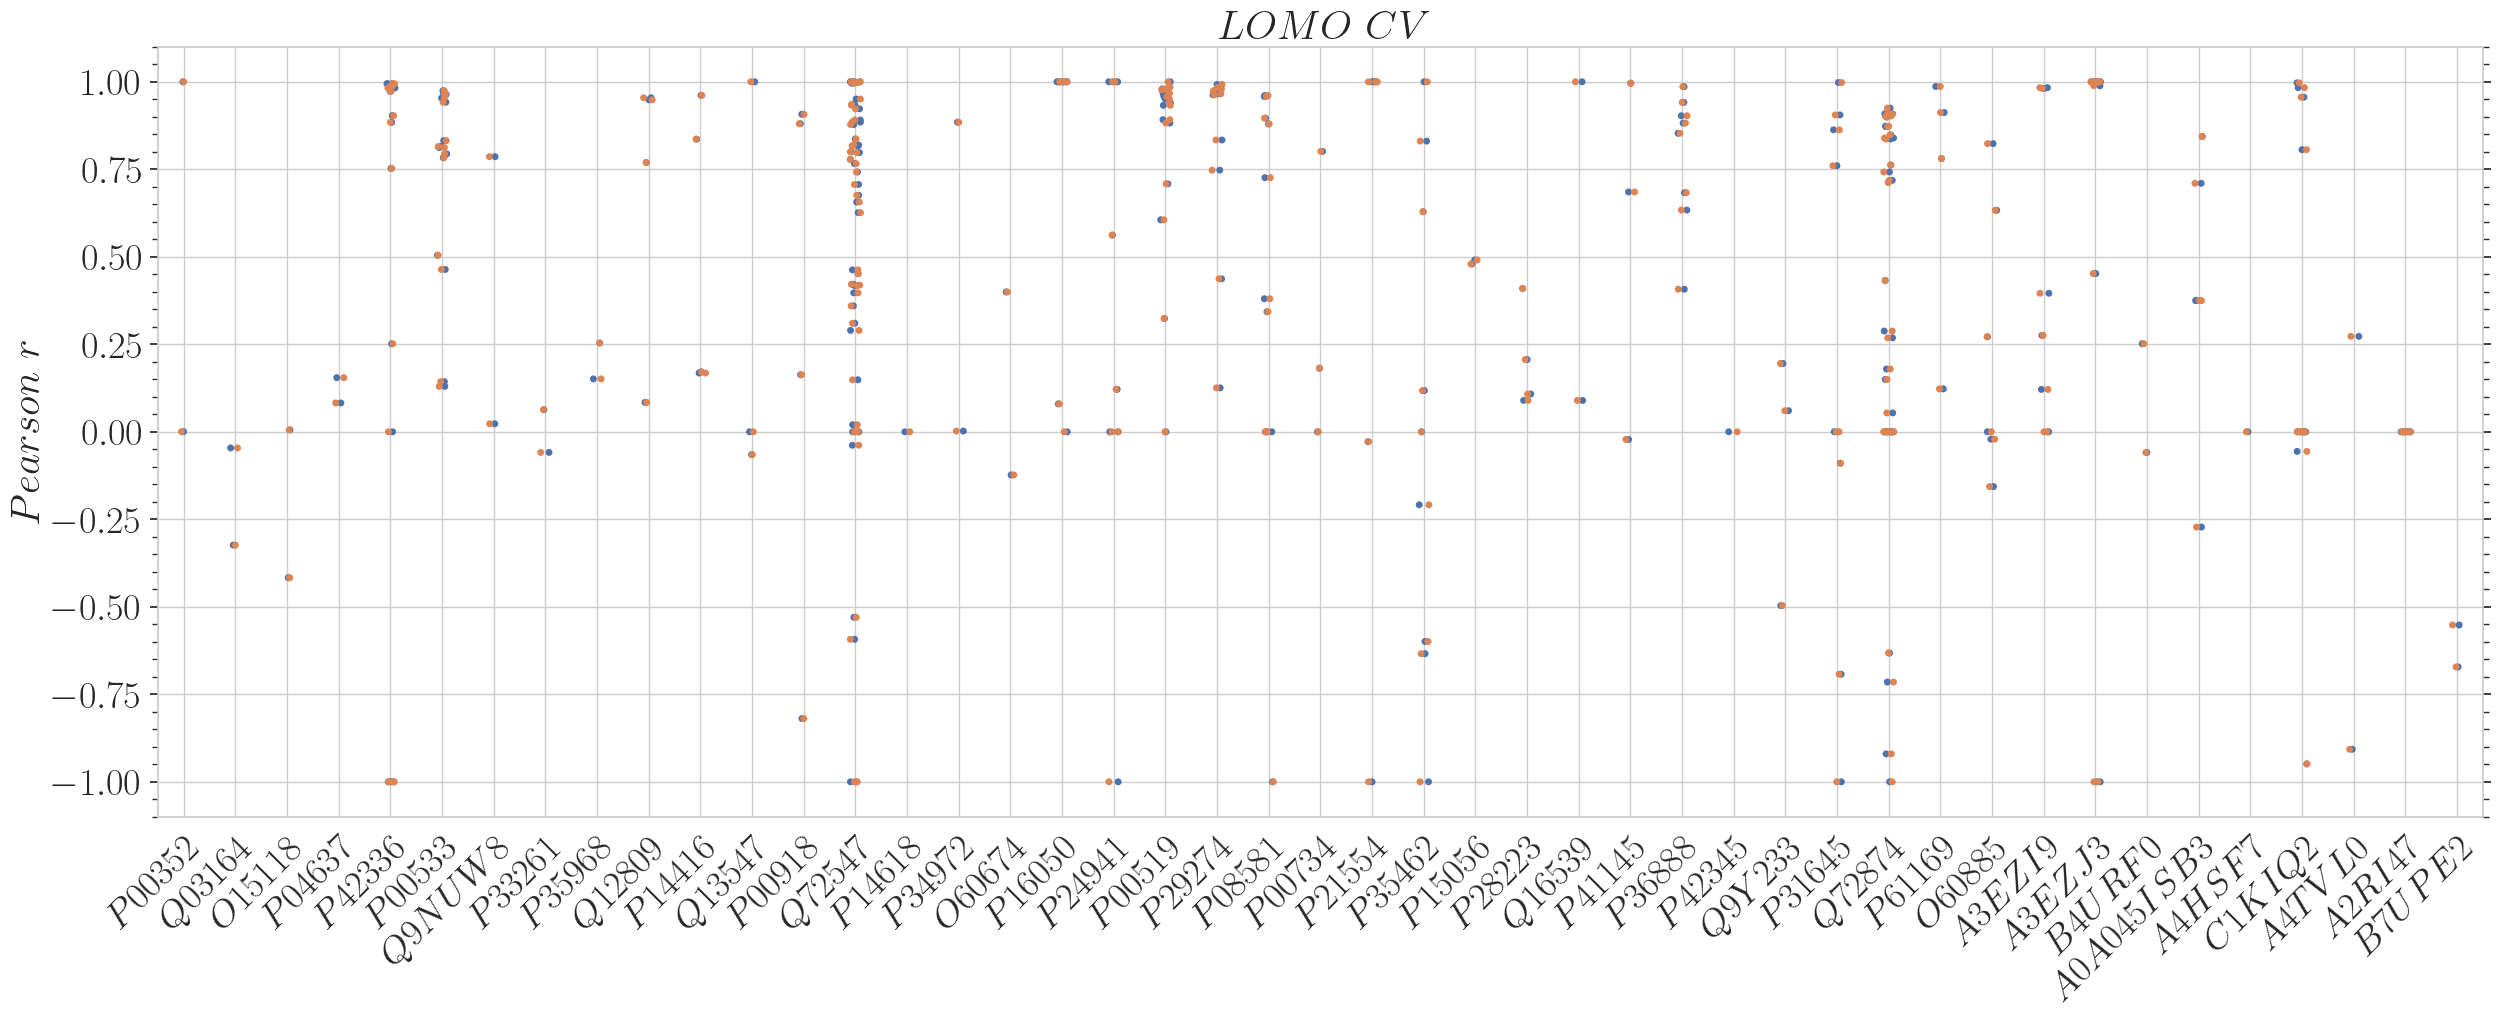

In [76]:
fig, ax = plt.subplots(figsize=(30, 10))

# Plot data
sns.stripplot(data=data[(data.crossval == 'per mutant') & (~data.folds.isin(['Mean', 'SD']))].reset_index(),
              x='accession', hue='modeltype', y=metrics, ax=ax, legend=False)
# Set title, axes labels and y limits
_ = ax.set(title='$LOMO$ $CV$', xlabel='', ylabel=' '.join(f'${word}$' for word in metrics.split()), ylim=(-1.1, 1.1))
# Rotate and right align x labels
_ = ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
# Adapt legend
handles, labels = ax.get_legend_handles_labels()
# Add minor ticks on y axis
ax.tick_params(axis='y', which='both', reset=True, direction='out')
ax.yaxis.set_major_locator(MultipleLocator(0.25))
ax.yaxis.set_minor_locator(MultipleLocator(0.05))
# Set grid on
ax.grid(True)
# Latex-ify x labels
_ = ax.set_xticklabels([' '.join(f'${word}$' for word in xtick.get_text().split()) for xtick in ax.get_xticklabels()])